# **Ex3 - Unsupervised learning**

## Names and IDs

1.   Etay Lorberboym - 314977596
2.   Peleg Gitnik - 208816827


In this assignemnt you will practice unsupervised methods we saw in class, and specifically running K-means and visualizing the data using PCA.

In this assignment you will learn a few more things:

1.   Load local files
2.   Load data from Kaggle
3. Use Scikit-learn K-means
4. Use Scikit-learn PCA
5. Some visulaization
6. Evaluate the performance of the clustering using Elbow methods, Siouhette analysis and accuracy (as we have true labels)

Note:
* Read the complete task before implementing.
* Reuse code, write functions.

## Import All Packages
Add all imports needed for this notebook to run

In [4]:
# Implement here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from keras.datasets import mnist
import matplotlib.cm as cm

# Text Clustering And Dimension Reduction

In this exercise you will cluster fake news using `k-means` and visualize the clustering using PCA.

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [5]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes
 78% 32.0M/41.0M [00:00<00:00, 123MB/s]
100% 41.0M/41.0M [00:00<00:00, 162MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


## 1. Read the csv files and create one single dataframe (5 points)

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [6]:
# Implement here
# Example for reading one file. It will work if the previous step was successful.
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

fake_df['label'] = 0 #fake label
true_df['label'] = 1 #true label

fake_df = fake_df[['text' , 'label']]
true_df = true_df[['text' , 'label']]

fake_true_Df = pd.concat([fake_df,true_df])

## 2. Cluster the samples into 2 clusters (real and fake) (15 points)

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`).
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [7]:
#performing TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 1000, stop_words = 'english')
text = fake_true_Df['text']
X = vectorizer.fit_transform(text)

#Scaling the data with Standartization
X = X.toarray()
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Applying KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

## 3. Visualize using scatter plot (20 points)
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction suing PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

Notes:

*   In clustering visualization it's important to also visualize the centroids.
* Visualize using matplotlib scatter function. It can be used to plot 2D or 3D scatter plots.

####Apply PCA

In [21]:
y_true = fake_true_Df['label']
pca = PCA()
Xt = pca.fit_transform(X)

####2D Plot

Text(0.5, 1.0, 'Clustering of the data using 2D plot')

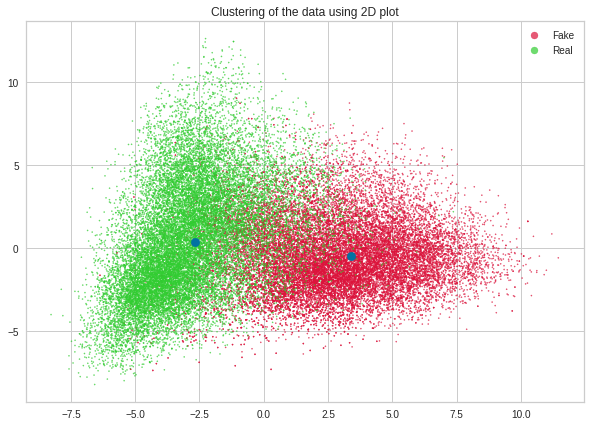

In [22]:
#Calculating centroids locations after applying PCA
centers = np.array(kmeans.cluster_centers_)
centers = pca.transform(centers)

#Plot over 2D grid
cmap = ListedColormap(['crimson','limegreen'])
plt.figure(figsize=(10,7))
plot = plt.scatter(Xt[:, 0], Xt[:, 1], c=y_true, cmap=cmap, alpha = 0.7 , s = 1.5)
plt.scatter(x = centers[:,0], y = centers[:,1], marker=".", color='b', s = 300)
plt.legend(handles=plot.legend_elements()[0], labels = ['Fake','Real'])
plt.title('Clustering of the data using 2D plot')

####3D Plot

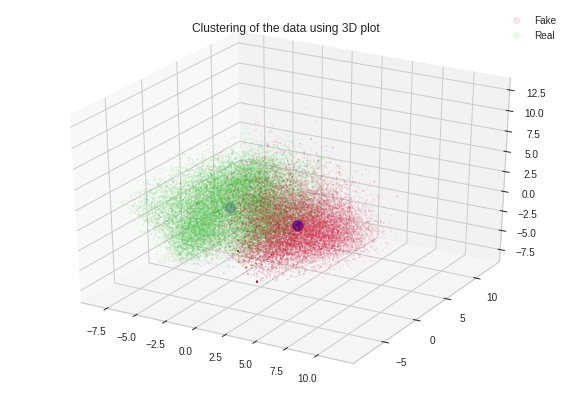

In [23]:
#set data in diffrent axis
x1 = Xt[:, 0]
x2 = Xt[:, 1]
x3 = Xt[:, 2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plot3d = ax.scatter(x1, x2, x3, c = y_true, cmap=cmap, alpha = 0.1 , s = 1.5 , zorder = 2)
ax.scatter(centers[:,0], centers[:,1],  marker=".", color='blue', s= 500, zorder = 1)
plt.legend(handles=plot3d.legend_elements()[0], labels = ['Fake','Real'])
plt.title('Clustering of the data using 3D plot')
plt.show()


## 4. Performance evaluation (15 points)
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [24]:
# Implement here
y_true = fake_true_Df.iloc[:,-1:].values
accuracy1 = accuracy_score(y_true, y_kmeans)

y_kmeans_flipped = 1 - y_kmeans
accuracy2 = accuracy_score(y_true, y_kmeans_flipped)

print('Accuracy when 1 is True and 0 is Fake is {}'.format(np.round(accuracy1,5)))
print('Accuracy when 0 is True and 1 is Fake is {}'.format(np.round(accuracy2,5)))

Accuracy when 1 is True and 0 is Fake is 0.12856
Accuracy when 0 is True and 1 is Fake is 0.87144


## 5. Find optimal `k` (20 points)
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.

Notes:
* You can get the SSD of a clustering using the `inertia_` attribute of the model.
* Silhouette score using `silhouette_score` function from `sklearn.metrics`. This function accept the model and the data.

In [25]:
# define k array
k_array = np.arange(2,21)
k_array

#define arrays to saved - silhouette and SSD values
SSD_array = []
silhouette_array = []

for k in k_array:

  curr_kmeans = KMeans(n_clusters=k, random_state=0)
  cluster_labels = curr_kmeans.fit_predict(Xt)
  SSD_array.append(curr_kmeans.inertia_)
  silhouette_avg = silhouette_score(Xt, cluster_labels, sample_size=300)
  silhouette_array.append(silhouette_avg)


In [26]:
#printing inertia values
print('SSD score and Silouette score for increasing k')
print()
for i in range(len(k_array)):
  print('For k = {} SSD = {} Silhouette = {}'.format(k_array[i],SSD_array[i] ,silhouette_array[i]))

SSD score and Silouette score for increasing k

For k = 2 SSD = 44477664.6748279 Silhouette = 0.014108813929921265
For k = 3 SSD = 44241414.41193289 Silhouette = -0.0016527939481022157
For k = 4 SSD = 44077203.029704295 Silhouette = 0.0037008704459113653
For k = 5 SSD = 43928409.87337254 Silhouette = 0.007301190480181925
For k = 6 SSD = 43795757.695601285 Silhouette = -0.004736646752676691
For k = 7 SSD = 43659774.62440449 Silhouette = -0.005994523591088124
For k = 8 SSD = 43526393.72872613 Silhouette = -0.04134648609474632
For k = 9 SSD = 43398814.120303914 Silhouette = -0.04390277022803546
For k = 10 SSD = 43316364.50811601 Silhouette = -0.01413595906454111
For k = 11 SSD = 43210865.132106744 Silhouette = -0.020070641170023162
For k = 12 SSD = 43104393.22419901 Silhouette = -0.007581933199869416
For k = 13 SSD = 43013846.790279604 Silhouette = -0.03688195975481558
For k = 14 SSD = 42935826.02565086 Silhouette = -0.053218191844170634
For k = 15 SSD = 42834280.2847474 Silhouette = -0.0

####Line Plot for Elbow method and Silhouette scores

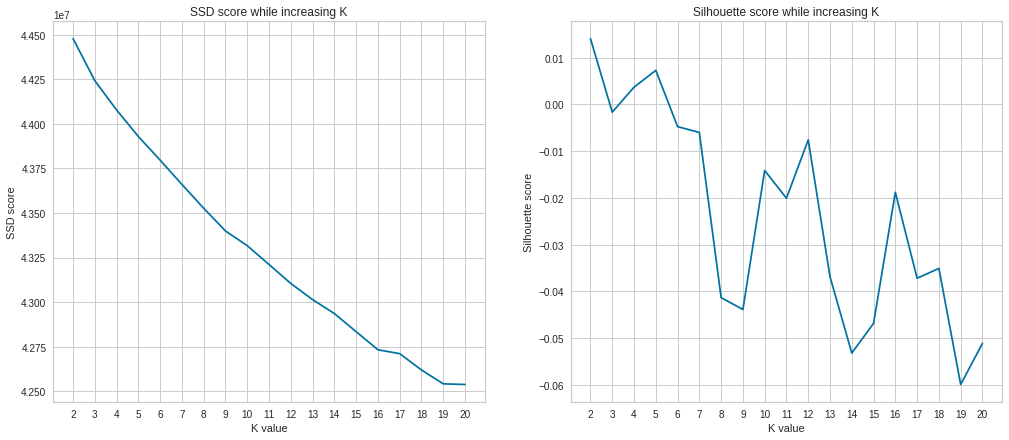

In [27]:
fig, axs = plt.subplots(1, 2,figsize=(17,7))
axs[0].plot(k_array,SSD_array)
axs[0].set_xlabel('K value')
axs[0].set_ylabel('SSD score')
axs[0].set_title('SSD score while increasing K')
axs[0].set_xticks(k_array)

axs[1].plot(k_array,silhouette_array)
axs[1].set_xlabel('K value')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette score while increasing K')
axs[1].set_xticks(k_array)

plt.show()

### 6. What is the optimal k for clustering? (10 

---

points)

* Explain.
* If optimal k!=2 what can be a good explanation for this?

<u>Explanation </u>

We can see from the 2 plots that the otimal k for the clustring algorithm is k = 2, as in the silhouette plot we recieve the highest score.
furthermore, we can see from the elbow graph that there are not significant change between the k's we check and the highest change from the changes is when we use k = 2 or k = 3.

When k != 2 the best result would be to take k = 4 as this k result recieve the better result then the other k's in both the elbow graph and the silhouette plot.
A good explanation for this outcome is because the most of the data point are close to each other (low covariance between the features) and because of that using higher k values would give us results that are less good then using a low value of k.

# 7. PCA then k-means (15 points)
This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.


####Generate TF-IDF 1000 features

In [28]:
""" Answer """
#Generate TF-IDF 1000 features
vectorizer = TfidfVectorizer(max_features = 1000,stop_words= 'english')
text = fake_true_Df['text']
X = vectorizer.fit_transform(text)
X = X.toarray()

#normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

####Run PCA

In [29]:
pca = PCA()
Xt2 = pca.fit_transform(X)

####Run k-means

In [30]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(Xt2)
y_kmeans2 = kmeans.predict(Xt2)

####Plot 2D and 3D scatter plots

Text(0.5, 1.0, 'Clustering of the data using 2D plot when applying PCA before running K-Means')

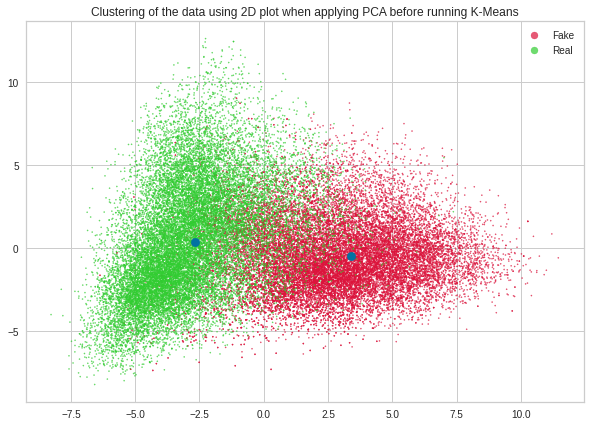

In [31]:
centers = np.array(kmeans.cluster_centers_)

plt.figure(figsize=(10,7))
plot = plt.scatter(Xt2[:, 0], Xt2[:, 1], c=y_true, cmap=cmap, alpha = 0.7 , s = 1.5)
plt.scatter(x = centers[:,0], y = centers[:,1], marker=".", color='b' , s = 300)
plt.legend(handles=plot.legend_elements()[0], labels = ['Fake','Real'])
plt.title('Clustering of the data using 2D plot when applying PCA before running K-Means')

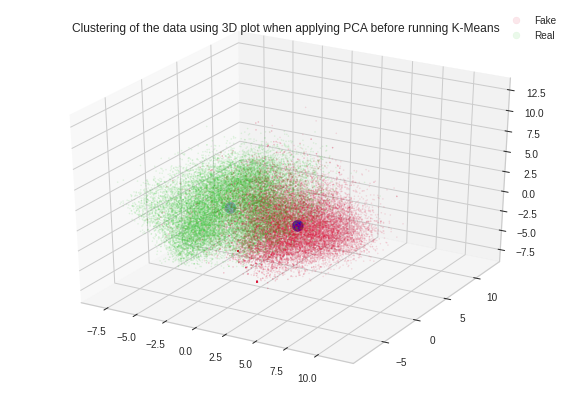

In [32]:
#set data in diffrent axis
x1 = Xt2[:, 0]
x2 = Xt2[:, 1]
x3 = Xt2[:, 2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
plot3d = ax.scatter(x1, x2, x3, c = y_true, cmap=cmap, alpha = 0.1 , s = 1.5)
ax.scatter(centers[:,0], centers[:,1],  marker=".", color='blue', s= 500)
plt.legend(handles=plot3d.legend_elements()[0], labels = ['Fake','Real'])
plt.title('Clustering of the data using 3D plot when applying PCA before running K-Means')
plt.show()

####Estimate the accuracy according to true labels.

In [33]:
accuracy1 = accuracy_score(y_true, y_kmeans2)

y_kmeans_flipped2 = 1 - y_kmeans2
accuracy2 = accuracy_score(y_true, y_kmeans_flipped2)

print('Accuracy when 1 is True and 0 is Fake is {}'.format(np.round(accuracy1,5)))
print('Accuracy when 0 is True and 1 is Fake is {}'.format(np.round(accuracy2,5)))

Accuracy when 1 is True and 0 is Fake is 0.12856
Accuracy when 0 is True and 1 is Fake is 0.87144


####Explain how is it compared to the previous approach, where clustering is performed w/o PCA.

<u>Explanation</u>

We can see from the graph and the accuracies that we recieve similar results as we did when we first applied the model and then applied PCA.
We know that when we apply PCA we tansform the data to the direction of the eigenvectors with the highest eigenvalues that we calculate from the covariance matrix, which measures the covariance between the features.
So when we apply this algorithm before and after the KMeans algorithm we should get diffrent results if the covariance of the fatures is high.
This transformation can affect the KMeans algorithm and change the clusters and the centroids because the data points might change their location, but as we see from the results we recieve similar results, which means that the covariance of the fauturs in our data is not high enaugh to change the results.


# Bonus (10 points)
Redo the same analysis, but this time using the MNIST data set. Notice that this time there are actually 10 'true' clusters.

1. What is the accuracy of the clustering when using k=10?
2. What is the optimal k?
3. How do the results changes if you first run PCA?

####Loading Data

We load the data from the keras library as we did in Assignment 1 of the course

In [34]:
#Download data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Reshape data
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

#Concatenate data
X_mnist = np.concatenate((x_train, x_test), axis= 0)
y_true_mnist = np.concatenate((y_train, y_test), axis= 0)

11501568/11490434 [==============================] - 0s 0us/step


#####answer 1

Applying k-Means with 10 clusters

In [35]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_mnist)
y_kmeans10 = kmeans.predict(X_mnist)

Calculating Accuracy Rate

Because the k-means algorithm does not classify the to the same results of the y true label we will use a function that correct the clustering and count for each cluster her outcome result by the majority votes.

In [36]:
def fix_accuracy(cluster_labels,y_train):
  # Initializing
  fixed_labels = {}
  # For loop to run through each label of cluster label
  for i in range(len(np.unique(kmeans.labels_))):
    j = np.where(cluster_labels == i,1,0)
    value = np.bincount(y_train[j==1]).argmax()
    fixed_labels[i] = value
  return fixed_labels

In [37]:
fixed_labels = fix_accuracy(kmeans.labels_,y_true_mnist)
num_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  num_labels[i] = fixed_labels[kmeans.labels_[i]]

accuracy_mnist = accuracy_score(y_true_mnist, num_labels)
print('Accuracy level for classifing MNIST with K-Means is {}'.format(accuracy_mnist))

Accuracy level for classifing MNIST with K-Means is 0.5850285714285715


####Answer 2

To check what is the optimal K we will use the Elbow Method from k = 2 to k = 20 (like did before).

In [38]:
k_array = np.arange(2,21)
k_array

SSD_array2 = []
silhouette_array2 = []
for k in k_array:
    #creating model with current k
    curr_kmeans = KMeans(n_clusters=k, random_state=0)
    curr_kmeans.fit(X_mnist)
    #adding the SSD value to array
    SSD_array2.append(curr_kmeans.inertia_)
    silhouette_avg = silhouette_score(X_mnist, curr_kmeans.labels_, sample_size=300)
    silhouette_array2.append(silhouette_avg)

In [39]:
#printing inertia values
for i in range(len(k_array)):
  print('For k = {} SSD = {} Silhouette = {}'.format(k_array[i], SSD_array2[i] ,silhouette_array2[i]))

For k = 2 SSD = 224609789945.67188 Silhouette = 0.09917808119753081
For k = 3 SSD = 213604853630.1691 Silhouette = 0.05326875328241878
For k = 4 SSD = 205222220730.71286 Silhouette = 0.0539594074369123
For k = 5 SSD = 197606835878.4074 Silhouette = 0.06502743711301655
For k = 6 SSD = 192102856639.10904 Silhouette = 0.0672794711769894
For k = 7 SSD = 188104385060.33145 Silhouette = 0.0605842135000313
For k = 8 SSD = 184475657590.9317 Silhouette = 0.07467912370948897
For k = 9 SSD = 181170519577.7211 Silhouette = 0.05670253426620163
For k = 10 SSD = 178432241736.41068 Silhouette = 0.06154820784885178
For k = 11 SSD = 175770330012.5769 Silhouette = 0.06479397611401029
For k = 12 SSD = 173323074556.7456 Silhouette = 0.055526986334066504
For k = 13 SSD = 171281036857.88318 Silhouette = 0.06497038728381434
For k = 14 SSD = 169266754757.5116 Silhouette = 0.07259559115522078
For k = 15 SSD = 167326280506.04858 Silhouette = 0.05847039889090699
For k = 16 SSD = 165682931616.27448 Silhouette = 0.

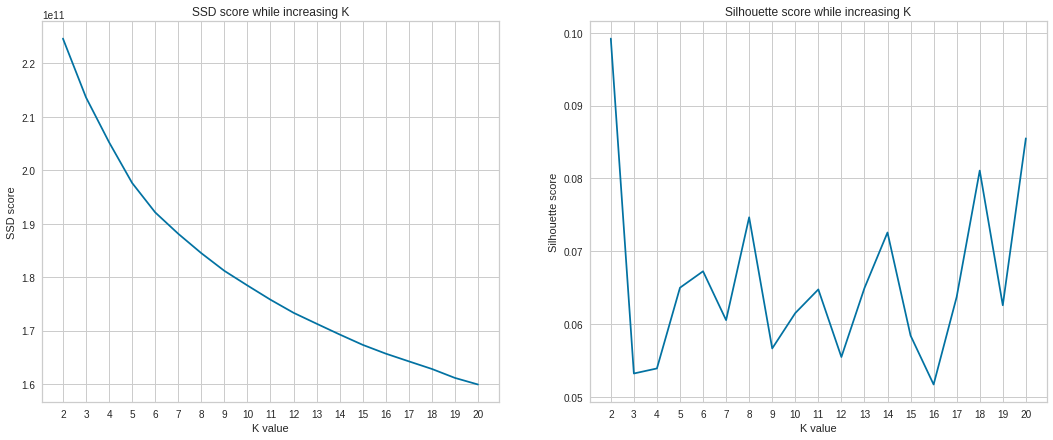

In [40]:
fig, axs = plt.subplots(1, 2,figsize=(18,7))
axs[0].plot(k_array,SSD_array2)
axs[0].set_xlabel('K value')
axs[0].set_ylabel('SSD score')
axs[0].set_title('SSD score while increasing K')
axs[0].set_xticks(k_array)

axs[1].plot(k_array,silhouette_array2)
axs[1].set_xlabel('K value')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette score while increasing K')
axs[1].set_xticks(k_array)

plt.show()

<u>Explanation</u>

We can notice that both of the graph yields diffrent results for k.
When we choose the optimal k by the Silouette graph which represents how dense and well separted the clusters are the best result would be to chhose k = 2 as it recieves the highest result.
From the elbow graph we notice that the result we recive are not significant as we cannot notice a value of k that is much better then the others.
When we look over the elbow graph a good choise would be to take a value of k between 6 and 8.
So if we would gather information from both of the graphs and choose the best k we would pick k = 8 as it recieve a good result in both of the graphs, the best k that will fit the data will be k = 8, as it brings the bests results in both of the graphs.





####Answer 3

We will check how the results change when first applying PCA and then after run the model.

####Apply PCA

In [41]:
pca = PCA()
X_mnist2 = pca.fit_transform(X_mnist)

####Apply K-Means

In [42]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_mnist2)

KMeans(n_clusters=10, random_state=0)

####Calculate Accuracy score

In [43]:
fixed_labels = fix_accuracy(kmeans.labels_,y_true_mnist)
num_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  num_labels[i] = fixed_labels[kmeans.labels_[i]]

accuracy_mnist = accuracy_score(y_true_mnist, num_labels)
print('Accuracy level for classifing MNIST with K-Means is {}'.format(accuracy_mnist))

Accuracy level for classifing MNIST with K-Means is 0.5850285714285715


####Search for optimal K with Elbow method

In [44]:

silhouette_array3 = []
SSD_array3 = []
for k in k_array:
    #creating model with current k
    curr_kmeans = KMeans(n_clusters=k, random_state=0)
    curr_kmeans.fit(X_mnist2)
    #adding the SSD value to array
    SSD_array3.append(curr_kmeans.inertia_)
    silhouette_avg = silhouette_score(X_mnist2, curr_kmeans.labels_, sample_size=300)
    silhouette_array3.append(silhouette_avg)

In [45]:
#printing inertia values
for i in range(len(k_array)):
  print('For k = {} SSD = {} Silhouette = {}'.format(k_array[i], SSD_array3[i] ,silhouette_array3[i]))

For k = 2 SSD = 224609789945.6718 Silhouette = 0.0938354925357165
For k = 3 SSD = 213604853630.16913 Silhouette = 0.05454957822863053
For k = 4 SSD = 205222220730.71283 Silhouette = 0.0654798547034435
For k = 5 SSD = 197606835878.4073 Silhouette = 0.06315338705024921
For k = 6 SSD = 192102856639.1092 Silhouette = 0.06557131176412437
For k = 7 SSD = 188104385060.33142 Silhouette = 0.06480863401739537
For k = 8 SSD = 184475657590.93158 Silhouette = 0.06982615083968231
For k = 9 SSD = 181170519577.72113 Silhouette = 0.051242763657000194
For k = 10 SSD = 178432241736.4107 Silhouette = 0.05027595810381016
For k = 11 SSD = 175770330012.5768 Silhouette = 0.050703145888221286
For k = 12 SSD = 173323074556.74564 Silhouette = 0.054983679402263425
For k = 13 SSD = 171281036857.88312 Silhouette = 0.05693366199735176
For k = 14 SSD = 169266754757.5116 Silhouette = 0.06034320295435807
For k = 15 SSD = 167326280506.04858 Silhouette = 0.05846781274073216
For k = 16 SSD = 165682931616.27448 Silhouette 

####Plot Elbow method

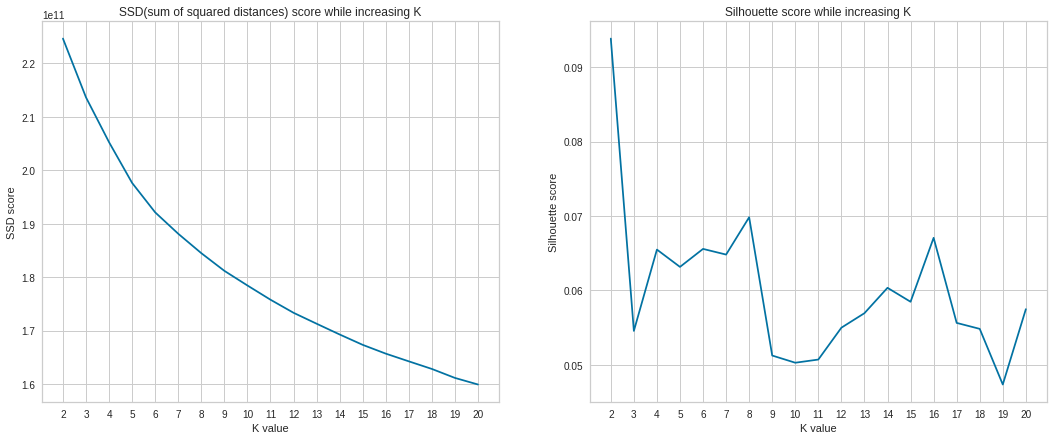

In [46]:
fig, axs = plt.subplots(1, 2,figsize=(18,7))
axs[0].plot(k_array,SSD_array3)
axs[0].set_xlabel('K value')
axs[0].set_ylabel('SSD score')
axs[0].set_title('SSD(sum of squared distances) score while increasing K')
axs[0].set_xticks(k_array)

axs[1].plot(k_array,silhouette_array3)
axs[1].set_xlabel('K value')
axs[1].set_ylabel('Silhouette score')
axs[1].set_title('Silhouette score while increasing K')
axs[1].set_xticks(k_array)

plt.show()

As can wee see from the two diffrent plots we created when we apply PCA and when we didnt apply the PCA , a k = 8 is a good choice for k as it gives good results in both of the plots for both the situations (with PCA and without).